<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/Human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


This error most likely means that this notebook is not configured to use a GPU.  Change this in Notebook Settings via the command palette (cmd/ctrl-shift-P) or the Edit menu.




SystemError: ignored

In [ ]:
import zipfile
with zipfile.ZipFile('HARDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('HARDataset')

In [ ]:
!cd HARDataset
!ls

HARDataset  HARDataset.zip  sample_data


In [ ]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from matplotlib import pyplot

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
import numpy as np
data = load_dataset('HARDataset/')

print('\ntrainX\n', data[0])
print('\ntrainY\n', data[1])
print('\ntestX\n', data[2])
print('\ntestY\n', data[3])

inputs = np.concatenate((data[0], data[2]), axis=0)
targets = np.concatenate((data[1], data[3]), axis=0)
print()
print(inputs)
print()
print(targets)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)

trainX
 [[[ 1.012817e+00 -1.232167e-01  1.029341e-01 ...  3.019122e-02
    6.601362e-02  2.285864e-02]
  [ 1.022833e+00 -1.268756e-01  1.056872e-01 ...  4.371071e-02
    4.269897e-02  1.031572e-02]
  [ 1.022028e+00 -1.240037e-01  1.021025e-01 ...  3.568780e-02
    7.485018e-02  1.324969e-02]
  ...
  [ 1.018445e+00 -1.240696e-01  1.003852e-01 ...  3.985177e-02
    1.909445e-03 -2.170124e-03]
  [ 1.019372e+00 -1.227451e-01  9.987355e-02 ...  3.744932e-02
   -7.982483e-05 -5.642633e-03]
  [ 1.021171e+00 -1.213260e-01  9.498741e-02 ...  2.881781e-02
   -3.771800e-05 -1.446006e-03]]

 [[ 1.018851e+00 -1.239760e-01  9.792958e-02 ...  1.711106e-02
    6.122797e-03  1.226815e-02]
  [ 1.022380e+00 -1.268078e-01  9.935086e-02 ...  2.417851e-02
    9.710357e-03  1.614958e-02]
  [ 1.020781e+00 -1.277862e-01  9.811381e-02 ...  3.022889e-02
    1.032192e-02  1.589471e-02]
  ...
  [ 1.014788e+00 -1.29

In [ ]:
#data[0][7351][127]
#inputs[7351][127]
from keras.datasets import cifar10
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  print("-------------------------------------------------------------------------------s")
  print("train")
  print(inputs[train])
  print("test")
  print(inputs[test])


-------------------------------------------------------------------------------s
train
[[[ 1.012817e+00 -1.232167e-01  1.029341e-01 ...  3.019122e-02
    6.601362e-02  2.285864e-02]
  [ 1.022833e+00 -1.268756e-01  1.056872e-01 ...  4.371071e-02
    4.269897e-02  1.031572e-02]
  [ 1.022028e+00 -1.240037e-01  1.021025e-01 ...  3.568780e-02
    7.485018e-02  1.324969e-02]
  ...
  [ 1.018445e+00 -1.240696e-01  1.003852e-01 ...  3.985177e-02
    1.909445e-03 -2.170124e-03]
  [ 1.019372e+00 -1.227451e-01  9.987355e-02 ...  3.744932e-02
   -7.982483e-05 -5.642633e-03]
  [ 1.021171e+00 -1.213260e-01  9.498741e-02 ...  2.881781e-02
   -3.771800e-05 -1.446006e-03]]

 [[ 1.018851e+00 -1.239760e-01  9.792958e-02 ...  1.711106e-02
    6.122797e-03  1.226815e-02]
  [ 1.022380e+00 -1.268078e-01  9.935086e-02 ...  2.417851e-02
    9.710357e-03  1.614958e-02]
  [ 1.020781e+00 -1.277862e-01  9.811381e-02 ...  3.022889e-02
    1.032192e-02  1.589471e-02]
  ...
  [ 1.014788e+00 -1.290268e-01  9.353520e-02

In [ ]:
a = []
i=1
b=[]
while i<=100:
  a.append(i)
  if i%2==0:
    b.append(True)
  else:
    b.append(False)
  i+=1
print(a)
print(b)


kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(a, b):
  print("-------------------------------------------------------------------------------s")
  print("train")
  print(np.array(a)[train.astype(int)])
  print(np.array(b)[train.astype(int)])
  print("test")
  print(np.array(a)[test.astype(int)])
  print(np.array(b)[test.astype(int)])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, T

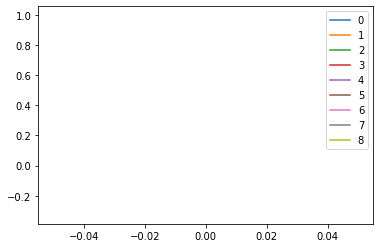

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(inputs[200][1]).T.plot()
plt.show()

In [ ]:
print(len(data[0]) + len(data[2]) )
print(len(inputs))

10299
10299


In [ ]:
def createLSTM(inputs, targets):
	iperparam = {"verbose": 0, "epochs": 15, "batch_size": 64}
	n_timesteps, n_features, n_outputs = inputs.shape[1], inputs.shape[2], targets.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	output = [model,iperparam]
	return output

def createCNNLSTM(inputs, targets):
	iperparam = {"verbose": 0, "epochs": 25, "batch_size": 64, "n_steps": 4, "n_length": 32, "n_features": 9}
	n_timesteps, n_features, n_outputs = inputs.shape[1], inputs.shape[2], targets.shape[1]
	# reshape data into time steps of sub-sequences
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,iperparam["n_length"],n_features)))
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
	model.add(TimeDistributed(Dropout(0.5)))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(100))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	output = [model,iperparam]
	return output

def createConvLSTM(inputs, targets):
		# define model
	iperparam = {"verbose": 0, "epochs": 25, "batch_size": 64, "n_steps": 4, "n_length": 32, "n_features": 9}
	n_timesteps, n_features, n_outputs = inputs.shape[1], inputs.shape[2], targets.shape[1]
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(iperparam["n_steps"], 1, iperparam["n_length"], n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	output = [model, iperparam]
	return output

In [ ]:
!pip install -q -U keras-tuner
from keras_tuner import RandomSearch
def buildModel(hp):
		# define model
	iperparam = {"verbose": 0, "epochs": 25, "batch_size": 64, "n_steps": 4, "n_length": 32, "n_features": 9}
	n_timesteps, n_features, n_outputs = inputs.shape[1], inputs.shape[2], targets.shape[1]
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(iperparam["n_steps"], 1, iperparam["n_length"], n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32), activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

tuner=RandomSearch(buildModel,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner1',
    project_name='Clothing')
trainX = data[0].reshape((data[0].shape[0], 4, 1, 32, 9))
testX = data[2].reshape((data[2].shape[0], 4, 1, 32, 9))
tuner.search(trainX,data[1],epochs=10,validation_data=(testX,data[3]))

     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 46.2 MB/s 

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |?                 |num_of_neurons

Epoch 1/10
 66/230 [=======>......................] - ETA: 13s - loss: 0.7465 - accuracy: 0.6955

KeyboardInterrupt: ignored

In [ ]:
def crossValidation(witchModel):
	from keras.datasets import cifar10
	from keras.losses import sparse_categorical_crossentropy
	from keras.optimizers import Adam
	from sklearn.model_selection import KFold
	import numpy as np

	num_folds = 5
	data = load_dataset('HARDataset/')

	# Merge inputs and targets
	inputs = np.concatenate((data[0], data[2]), axis=0)
	targets = np.concatenate((data[1], data[3]), axis=0)

	# Define the K-fold Cross Validator
	kfold = KFold(n_splits=num_folds, shuffle=True)

	# K-fold Cross Validation model evaluation
	fold_no = 1
	acc_per_fold, loss_per_fold = [],[]
	#verbose, epochs, batch_size = 0, 15, 64
	for train, test in kfold.split(inputs, targets):
	
		if(witchModel == 1):
  	# Define the model architecture
			lista = createLSTM(inputs, targets)
			model, iperparam = lista[0], lista[1]
			trainX = inputs[train]
			testX = inputs[test]
		elif(witchModel == 2):
			lista = createCNNLSTM(inputs, targets)
			model, iperparam = lista[0], lista[1]		
			trainX = inputs[train].reshape((inputs[train].shape[0], iperparam["n_steps"], iperparam["n_length"], iperparam["n_features"]))
			testX = inputs[test].reshape((inputs[test].shape[0], iperparam["n_steps"], iperparam["n_length"], iperparam["n_features"]))
		elif(witchModel == 3):
			lista = createConvLSTM(inputs, targets)
			model, iperparam = lista[0], lista[1]		
			trainX = inputs[train].reshape((inputs[train].shape[0], iperparam["n_steps"], 1, iperparam["n_length"], iperparam["n_features"]))
			testX = inputs[test].reshape((inputs[test].shape[0], iperparam["n_steps"], 1, iperparam["n_length"], iperparam["n_features"]))
	
		print('------------------------------------------------------------------------')
		print(f'Training for fold {fold_no} ...')
		print('Number of train exaple:', inputs[train].shape[0])
		print('Number of test exaple:', targets[test].shape[0])
  
  	# Fit data to model
		history = model.fit(trainX, targets[train],
    	          batch_size=iperparam["batch_size"],
      	        epochs=iperparam["epochs"],
        	      verbose=iperparam["verbose"])
  # Generate generalization metrics
	#	scores = model.evaluate(inputs[test], targets[test], verbose=0)
		scores = model.evaluate(testX, targets[test], verbose=0)
		print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
		acc_per_fold.append(scores[1] * 100)
		loss_per_fold.append(scores[0])

  	# Increase fold number
		fold_no = fold_no + 1

	averageAccuracy = f'{sum(acc_per_fold)/len(acc_per_fold):,.2f}'
	averageLoss = f'{sum(loss_per_fold)/len(loss_per_fold):,.4f}'
	print('------------------------------------------------------------------------')
	print('Average accuracy on {} folds: {}%' .format(num_folds, averageAccuracy))
	print('Average loss on {} folds: {}' .format(num_folds, averageLoss))
	return averageAccuracy, averageLoss

In [ ]:
from prettytable import PrettyTable
print("===================================================================")
print("                     LSTM                                          ")
print("===================================================================")
lstmAccuracy, lstmLoss = crossValidation(1)
print("===================================================================")
print("                     CLSTM                                         ")
print("===================================================================")
clstmAccuracy, clstmLoss = crossValidation(2)
print("===================================================================")
print("                     ConvLSTM                                          ")
print("===================================================================")
convLstmAccuracy, convLstmLoss = crossValidation(3)
compareModel = PrettyTable()
compareModel.field_names = ["Model", "Average Accuracy", "Average loss"]
compareModel.add_row(["lstm", lstmAccuracy, lstmLoss])
compareModel.add_row(["CLstm", clstmAccuracy, clstmLoss])
compareModel.add_row(["Convlstm", convLstmAccuracy, convLstmLoss])
print(compareModel)

                     LSTM                                          
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
------------------------------------------------------------------------
Training for fold 1 ...
Number of train exaple: 8239
Number of test exaple: 2060
Score for fold 1: loss of 0.13012756407260895; accuracy of 94.12621259689331%
------------------------------------------------------------------------
Training for fold 2 ...
Number of train exaple: 8239
Number of test exaple: 2060
Score for fold 2: loss of 0.1621762067079544; accuracy of 93.49514842033386%
------------------------------------------------------------------------
Training for fold 3 ...
Number of train exaple: 8239
Number of test exaple: 2060
Score for fold 3: loss of 0.13326263427734375; accuracy of 94.51456069946289%
------------------------------------------------------------------------
Training for fold 4 ...
Number of train exaple: 8239
Number of t

KeyboardInterrupt: ignored

In [ ]:
compareModel

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

def confusionMatrix(predictions, testy):
	y_pred = np.argmax(predictions, axis=-1)
	#print(y_pred)
	#print(predictions)
	y_true=np.argmax(testy, axis=-1)
	cm = confusion_matrix(y_true, y_pred)
 ## Get Class Labels
	labels = ["Walking", "Walking upstairs", "Walking downstairs",
           "Sitting", "Standing", "Laying"]
	class_names = labels

# Plot confusion matrix in a beautiful manner
	fig = plt.figure(figsize=(16, 14))
	ax= plt.subplot()
	sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
	ax.set_xlabel('Predicted', fontsize=20)
	ax.xaxis.set_label_position('bottom')
	plt.xticks(rotation=90)
	ax.xaxis.set_ticklabels(class_names, fontsize = 10)
	ax.xaxis.tick_bottom()

	ax.set_ylabel('True', fontsize=20)
	ax.yaxis.set_ticklabels(class_names, fontsize = 10)
	plt.yticks(rotation=0)

	plt.title('Confusion Matrix', fontsize=20)

	plt.show()
 
# fit and evaluate a model
def evaluate_LSTM_model(trainX, trainy, testX, testy):
	lista = createLSTM(trainX, trainy)
	model, hyperparam = lista[0],lista[1]
	# fit network
	model.fit(trainX, trainy, epochs=hyperparam['epochs'],
           batch_size=hyperparam['batch_size'], verbose=hyperparam['verbose'])
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=hyperparam['batch_size'], verbose=0)
 
	#predictions = model.predict(testX)
	#confusionMatrix(predictions, testy)
	return accuracy, model

def evaluate_CNNLSTM_model(trainX, trainy, testX, testy):
	# define model
	lista = createCNNLSTM(trainX, trainy)
	model, hyperparam = lista[0], lista[1]
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape data into time steps of sub-sequences
	n_steps, n_length = 4, 32
	trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
	# fit network
	model.fit(trainX, trainy, epochs=hyperparam['epochs'], batch_size=hyperparam['batch_size'],
           verbose=hyperparam['verbose'])
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=hyperparam['batch_size'], verbose=0)
	return accuracy, model

# fit and evaluate a model
def evaluate_ConvLSTM_model(trainX, trainy, testX, testy):
	# define model
	lista = createConvLSTM(trainX, trainy)
	model, hyperparam = lista[0], lista[1]
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape into subsequences (samples, time steps, rows, cols, channels)
	n_steps, n_length = 4, 32
	trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
	# fit network
	model.fit(trainX, trainy, epochs=hyperparam['epochs'], batch_size=hyperparam['batch_size'],
           verbose=hyperparam['verbose'])
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=hyperparam['batch_size'], verbose=0)
	return accuracy, model

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
	return m,s

# run an experiment
def run_experiment(repeats=10, selectModel=3):
	# load data
	trainX, trainy, testX, testy = load_dataset('HARDataset/')
	# repeat experiment
	scores = list()
	bestScore = 0

	for r in range(repeats):
		if selectModel == 1:
				score, model = evaluate_LSTM_model(trainX, trainy, testX, testy)
		elif selectModel == 2:
				score, model = evaluate_CNNLSTM_model(trainX, trainy, testX, testy) 
				n_steps, n_length, n_features = 4, 32, trainX.shape[2]
				testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
		elif selectModel == 3:
				score, model = evaluate_ConvLSTM_model(trainX, trainy, testX, testy)   
				n_steps, n_length, n_features = 4, 32, trainX.shape[2]
				testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
		score = score * 100.0
		if score > bestScore:
				bestScore = score
				bestModel = model
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	predictions = bestModel.predict(testX)
	confusionMatrix(predictions, testy)
	# summarize results
	return summarize_results(scores)

In [ ]:
from prettytable import PrettyTable
# run the experiment
print("====================================================")
print("                     LSTM                           ")
print("====================================================")
averageAccuracy1, var1 = run_experiment(10,1)
print("====================================================")
print("                   CNNLSTM                          ")
print("====================================================")
averageAccuracy2, var2 = run_experiment(10,2)
print("====================================================")
print("                  ConvLSTM                          ")
print("====================================================")
averageAccuracy3, var3 = run_experiment(10,3)
compareModel = PrettyTable()
compareModel.field_names = ["Model", "Average Accuracy", "Variance"]
compareModel.add_row(["lstm", averageAccuracy1, var1])
compareModel.add_row(["CLstm", averageAccuracy2, var2])
compareModel.add_row(["Convlstm", averageAccuracy3, var3])
print(compareModel)